# Workshop: Explaining and Interpreting XGBoost Models

## Setup and Preliminaries
### Notebook is in the following repo: www.github.com/numeristical/resources
- #### Clone or download the repo
- #### Navigate to folder "ODSC_Europe_2020"
- #### Find notebook file inside folder "ODSC_Europe_2020_Interpretability.ipynb"
- #### Use this link to get the data: https://cutt.ly/YfUsg0N (then click on download)
- #### Put 'ins_data.csv' in the "ODSC_Europe_2020" folder
- #### Check Slack channel for any updates to instructions

### Suggestion: make a copy of Notebook, go to Kernel->Restart and Clear All Outputs
(This way you can make changes and still refer to the original)

# About Me
## Brian Lucena
- ### Consultant, Researcher, Educator: www.numeristical.com
- ### Work with many startups, as well as larger (public) companies
- ### Youtube channel on Statistical Machine Learning: https://www.youtube.com/channel/UCfsbASar8nsLs4NbhQwuaVg
- ### ML-Insights package: Model Interpretability, Probability Calibration (SplineCalib) www.github.com/numeristical/introspective
- ### StructureBoost package: Gradient Boosting with Categorical Structure: www.github.com/numeristical/structureboost
- ### Research Papers:
    - "Exploiting Categorical Structure using Tree-based Methods" (AISTATS 2020) http://proceedings.mlr.press/v108/lucena20a/lucena20a.pdf
    - "StructureBoost: Efficient Gradient Boosting for Structured Categorical Variables" https://arxiv.org/abs/2007.04446
    - "Spline-Based Probability Calibration" https://arxiv.org/abs/1809.07751
- ### Upcoming Talks and Workshops
    - ODSC West (Virtual): (StructureBoost) October 27-30: https://odsc.com/speakers/structureboost-gradient-boosting-with-categorical-structure/
    - ODSC Live Training: "Gradient Boosting for Prediction and Inference": November 10, 2020 https://aiplus.odsc.com/courses/gradient-boosting-for-prediction-and-inference
    - PyData Global 2020 (Calibration) November 11-15, https://global.pydata.org/
    - Data Science UA (StructureBoost) November 20, https://data-science-ua.com/conference/
    

# Workshop Overview
## This workshop will focus on two primary objectives:

### Understanding the overall dynamics of your data and your model:

- #### Using sophisticated modeling packages (like XGBoost) to understand more complicated dynamics in the data

- #### How to approach data exploration to understand more complicated relationships between the variables in your data

- #### Why the "coherence" of a model is important - arguably, on the same level as its predictive performance

- #### How to assess the "coherence" of a model using ICE plots 

### Understanding and explaining individual predictions from the model

- #### How to ascribe "reasons" to individual predictions

- #### How to "consolidate" features to make the reasons more coherent and understandable

- #### Using visualizations independently and from the SHAP package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('classic')  # I prefer the appearance of the "old-school" color scheme
from sklearn.metrics import roc_auc_score, confusion_matrix, log_loss, accuracy_score, r2_score, roc_curve, precision_recall_curve
import xgboost as xgb


pd.set_option("display.max_rows",999)
pd.set_option("display.max_columns",999)
np.set_printoptions(edgeitems=30, linewidth=100000)

In [2]:
# must have ml_insights installed ('pip install ml_insights')
# !pip install ml_insights
import ml_insights as mli

# version should be 0.1.5 or higher
mli.__version__

'0.1.5'

In [3]:
# Make sure data is downloaded and in the folder
df_ins = pd.read_csv('ins_data.csv')
df_ins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6820 entries, 0 to 6819
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   has_umbrella               6820 non-null   int64  
 1   homeown_premium            6820 non-null   float64
 2   auto_premium               6820 non-null   float64
 3   num_home_pol               6820 non-null   float64
 4   home_dwell_cov             6820 non-null   float64
 5   home_pers_prop_cov         6820 non-null   float64
 6   num_vehicles               6820 non-null   float64
 7   max_vehicle_year           6820 non-null   float64
 8   min_vehicle_year           6820 non-null   float64
 9   num_drivers_by_dob         6820 non-null   float64
 10  yob_policyholder           6820 non-null   float64
 11  max_driver_yob             6820 non-null   float64
 12  min_driver_yob             6820 non-null   float64
 13  state_abbrev               6820 non-null   objec

## Data Exploration
This data set contains information about different insurance customers who have both home insurance and auto insurance with an agency.  The information includes their premiums, coverages, vehicles, drivers, state of residence, and zip-code demographics.


In this exercise we will be building a model to predict who is likely to have an umbrella policy.  Imagine, that our goal is to be able to recommend to new agencies (which currently don't sell umbrella policies) which customers are the best candidates.  Our binary outcome variable is `has_umbrella` 

We will focus on techniques for exploring, understanding, and interpreting data and models in a binary classification framework.


### Look at the "baseline" (marginal) probability of the outcome variable
It is always a good idea to know ahead of time what the baseline probability of your outcome variable is.  Without this information, it is difficult to properly interpret the effectiveness of your model.

In [4]:
df_ins.has_umbrella.value_counts(), np.mean(df_ins.has_umbrella)

(0    5799
 1    1021
 Name: has_umbrella, dtype: int64, 0.1497067448680352)

### Initial Predictors
To start, let's look only at the variables `homeown_premium` and `auto_premium` and see how they relate to the outcome variable `has_umbrella`

(array([6.345e+03, 4.070e+02, 4.500e+01, 1.400e+01, 5.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([    0.,  2165.,  4330.,  6495.,  8660., 10825., 12990., 15155., 17320., 19485., 21650.]),
 <a list of 10 Patch objects>)

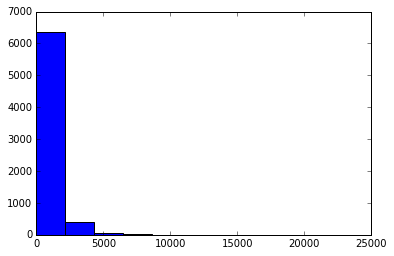

In [5]:
plt.hist(df_ins.homeown_premium)

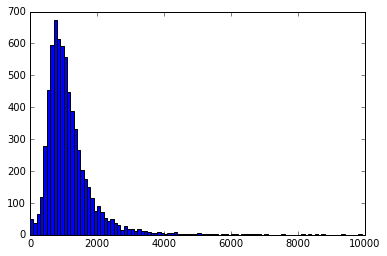

In [6]:
# TIP: Generally a good idea to put in custom bin widths

plt.hist(df_ins.homeown_premium, bins=np.linspace(0,10000,101));

In [7]:
# Histogram Pair function
# Good way to visually examine relationship between a numerical predictor
# and a binary target
# Given a set of bins, shows the P(target) for predictor in that bin value.

bins_1 = np.linspace(0,2000,9)
bins_2 = np.array([2000,3000, 6000, 10000])
bins_final = np.unique(np.concatenate((bins_1, bins_2)))
bins_final

array([    0.,   250.,   500.,   750.,  1000.,  1250.,  1500.,  1750.,  2000.,  3000.,  6000., 10000.])

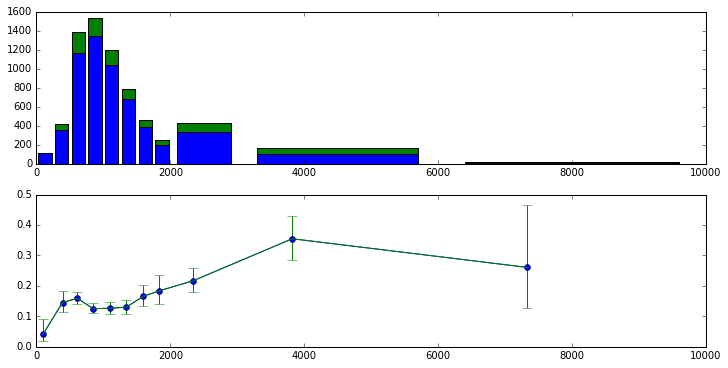

In [8]:
mli.histogram_pair(df_ins.homeown_premium, df_ins.has_umbrella, bins=bins_final);

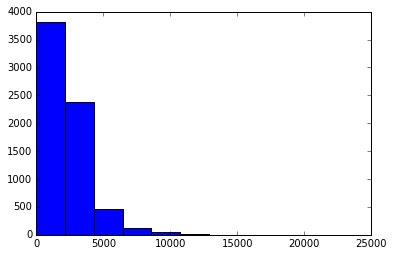

In [9]:
plt.hist(df_ins.auto_premium);

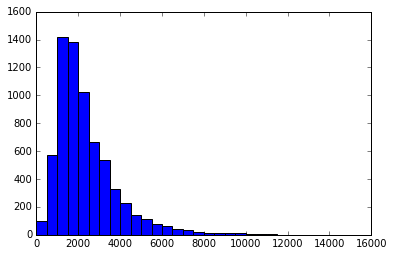

In [10]:
plt.hist(df_ins.auto_premium,np.linspace(0,15000,30+1));

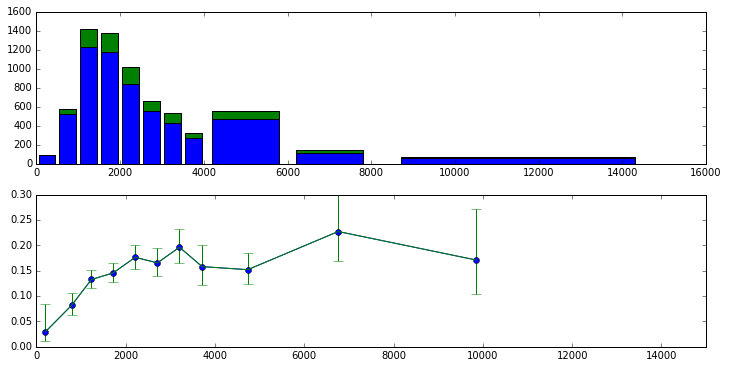

In [11]:
bins_1 = np.linspace(0,4000,8+1)
bins_2 = np.array([4000,6000, 8000, 15000])
bins_final = np.unique(np.concatenate((bins_1, bins_2)))
mli.histogram_pair(df_ins.auto_premium, df_ins.has_umbrella, bins=bins_final);

In [12]:
## Could do this on all the variables to understand...

## Simple model: 2 variables

It is often a good idea to build a model on a small number of variables first, just to get a sense of the behavior.

In [13]:
chosen_fold_variant = 'fold_num_1'
test_fold_num = 0

In [14]:
features_1 = ['auto_premium','homeown_premium']

## Question
- ###  How high do you expect your precision to get? (at, say, recall=.1)

In [15]:
# Define train and test sets

X_train_1 = df_ins.loc[df_ins[chosen_fold_variant]!=test_fold_num,features_1]
X_test_1 = df_ins.loc[df_ins[chosen_fold_variant]==test_fold_num,features_1]

y_train = df_ins.has_umbrella[df_ins[chosen_fold_variant]!=test_fold_num]
y_test = df_ins.has_umbrella[df_ins[chosen_fold_variant]==test_fold_num]

### First model - default XGBoost

In [16]:
xgb_def1 = xgb.XGBClassifier()

In [17]:
xgb_def1.fit(X_train_1,y_train)
pred_probs_def1 = xgb_def1.predict_proba(X_test_1)[:,1]

### Question: How should we evaluate this model?

In [18]:
roc_auc_score(y_test, pred_probs_def1), log_loss(y_test, pred_probs_def1)

(0.5593078688964107, 0.43412508282348267)

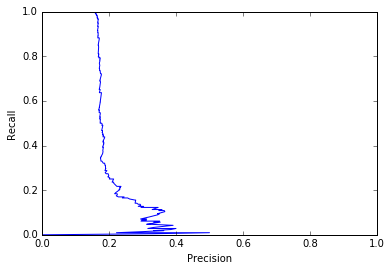

In [19]:
mli.plot_pr_curves([y_test],[pred_probs_def1])

### To Do: Perform your own evaluation of the model here

## Other less utilized ways to "examine" your model
- ### Calibration (Reliability Diagram)
- ### Variation to individual Parameter changes (Individual Conditional Expectation (ICE) plots)
- ### Coherence - does the "story" of the model hold together?

### Calibration
#### Idea: When your model predicts probability of 20%, does it really happen 20% of the time?
#### Method: 
- #### Look at test set when your model predicted outcome 1 with a probability of (approximately) 20%.  
- #### Look at fraction that actually occured.
- #### Determine if it is within the expected range of frequency if the probability were accurate
- #### Doing this requires *binning* the data

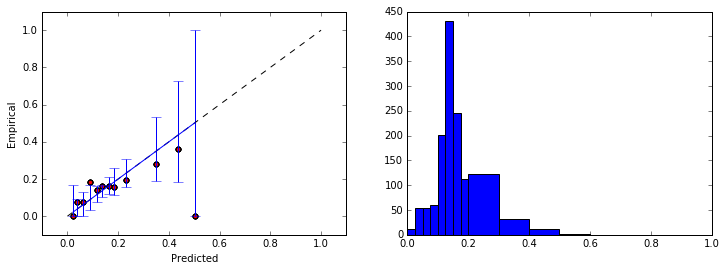

In [20]:
# Predicted probabilities on the x-axis
# Empirical ("actual") probabilities on the y-axis
# "Expected" variation (based on binomial distribution) measured by error bars

plt.figure(figsize=(12,4))
bins1 = np.linspace(0,.2,8+1)
bins2 = np.linspace(.2,1,8+1)
bins_final = np.unique(np.concatenate((bins1, bins2)))

mli.plot_reliability_diagram(y_test,pred_probs_def1, bins=bins_final,
                            show_histogram=True);

### Question: What do you think of the above reliability diagram?

### Individual Conditional Expectation Plot
### Idea: 
- #### Hold all features constant except for one.
- #### Vary the value of the feature over a range of values
- #### Examine how the model prediction changes
- #### Examine how the response curve may take different shapes (because of interactions)

In [21]:
mli.ice_plot?

Signature:
mli.ice_plot(
    model,
    base_data,
    column_names,
    range_pts,
    show_base_pt=True,
    show_nan=False,
    pred_fn='predict_proba',
    class_num=1,
    figsize='auto',
    plots_per_row=3,
    y_scaling='none',
)
Docstring:
Generates an ICE plot for a model and data points.

ICE (Individual Conditional Expectation) plots are a tool for
understanding model predictions. Given a model, a 'base' data point,
a column, and a range of values, it will plot the model prediction
as we change the selected column across the range of values (holding
all other variables constant).

This function was developed for use with Jupyter notebooks using
the 'inline' option for matplotlib.

Parameters
----------

model : model object
    The model whose behavior we are examining.  Most models are
    supported as long as they are equipped with a "predict" or 
    "predict_proba" method.

base_data : pandas Series or DataFrame
    The point or points to use as the "base". One curve wi

In [22]:
# Choose a few test points
np.random.seed(0)
test_sample_1 = X_test_1.sample(3)

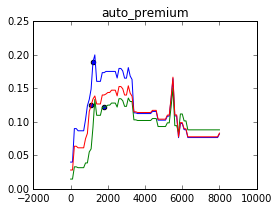

In [23]:
# For a single feature:
mli.ice_plot(model=xgb_def1,
            base_data=test_sample_1,
            column_names='auto_premium',
            range_pts=np.linspace(0,8000,81),
            )

In [24]:
# Get reasonable ranges for all variables
rd = mli.get_range_dict(X_train_1)
rd

{'auto_premium': array([    0.        ,   107.78894472,   215.57788945,   323.36683417,   431.15577889,   538.94472362,   646.73366834,   754.52261307,   862.31155779,   970.10050251,  1077.88944724,  1185.67839196,  1293.46733668,  1401.25628141,  1509.04522613,  1616.83417085,  1724.62311558,  1832.4120603 ,  1940.20100503,  2047.98994975,  2155.77889447,  2263.5678392 ,  2371.35678392,  2479.14572864,  2586.93467337,  2694.72361809,  2802.51256281,  2910.30150754,  3018.09045226,  3125.87939698,  3233.66834171,  3341.45728643,  3449.24623116,  3557.03517588,  3664.8241206 ,  3772.61306533,  3880.40201005,  3988.19095477,  4095.9798995 ,  4203.76884422,  4311.55778894,  4419.34673367,  4527.13567839,  4634.92462312,  4742.71356784,  4850.50251256,  4958.29145729,  5066.08040201,  5173.86934673,  5281.65829146,  5389.44723618,  5497.2361809 ,  5605.02512563,  5712.81407035,  5820.60301508,  5928.3919598 ,  6036.18090452,  6143.96984925,  6251.75879397,  6359.54773869,  6467.33668342, 

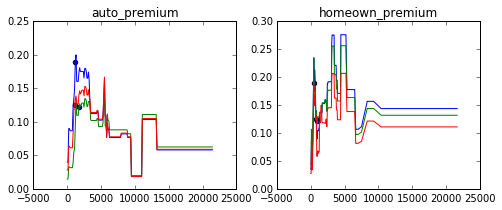

In [25]:
## Make ICE plots for all features using the dictionary
mli.ice_plot(model=xgb_def1, 
             column_names=X_train_1.columns, 
             range_pts=rd, 
             base_data=test_sample_1)

In [26]:
# Use my own ranges 
rd['auto_premium'] = np.linspace(0, 5000, 51)
rd['homeown_premium'] = np.linspace(0, 5000, 51)
rd

{'auto_premium': array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900., 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700., 1800., 1900., 2000., 2100., 2200., 2300., 2400., 2500., 2600., 2700., 2800., 2900., 3000., 3100., 3200., 3300., 3400., 3500., 3600., 3700., 3800., 3900., 4000., 4100., 4200., 4300., 4400., 4500., 4600., 4700., 4800., 4900., 5000.]),
 'homeown_premium': array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900., 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700., 1800., 1900., 2000., 2100., 2200., 2300., 2400., 2500., 2600., 2700., 2800., 2900., 3000., 3100., 3200., 3300., 3400., 3500., 3600., 3700., 3800., 3900., 4000., 4100., 4200., 4300., 4400., 4500., 4600., 4700., 4800., 4900., 5000.])}

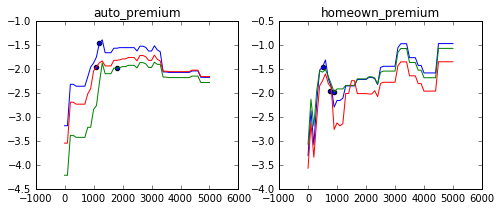

In [27]:
mli.ice_plot(model=xgb_def1, 
             column_names=X_train_1.columns, 
             range_pts=rd, 
             base_data=test_sample_1,
             y_scaling='logit')

## Question: What do you think about these ICE plots?

### Second model: Let's try adding a bit more regularization

- use an "eval_set" and early stopping
- low learning rate and high number of trees (since it will early stop anyway)
- smaller `max_depth`
- `subsample` percentage
- larger `gamma` and `reg_lambda`

In [28]:
xgb_complex1 = xgb.XGBClassifier(n_estimators=1000, learning_rate=.01, gamma=5,
                                 max_depth=2, subsample=.9, 
                                 reg_lambda=3)


In [29]:
xgb_complex1.fit(X_train_1,y_train, eval_set=[(X_test_1, y_test)], 
                 eval_metric='logloss', early_stopping_rounds = 50)
pred_probs_complex_1 = xgb_complex1.predict_proba(X_test_1)[:,1]


[0]	validation_0-logloss:0.688316
Will train until validation_0-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.683585
[2]	validation_0-logloss:0.678929
[3]	validation_0-logloss:0.674391
[4]	validation_0-logloss:0.669905
[5]	validation_0-logloss:0.66556
[6]	validation_0-logloss:0.661283
[7]	validation_0-logloss:0.657071
[8]	validation_0-logloss:0.652906
[9]	validation_0-logloss:0.648884
[10]	validation_0-logloss:0.644952
[11]	validation_0-logloss:0.64111
[12]	validation_0-logloss:0.637314
[13]	validation_0-logloss:0.633592
[14]	validation_0-logloss:0.629893
[15]	validation_0-logloss:0.626373
[16]	validation_0-logloss:0.62287
[17]	validation_0-logloss:0.619443
[18]	validation_0-logloss:0.616012
[19]	validation_0-logloss:0.612687
[20]	validation_0-logloss:0.609404
[21]	validation_0-logloss:0.606176
[22]	validation_0-logloss:0.603019
[23]	validation_0-logloss:0.599926
[24]	validation_0-logloss:0.596908
[25]	validation_0-logloss:0.593962
[26]	validation_0-logloss:0.59103
[

In [30]:
## Performance of this model
roc_auc_score(y_test, pred_probs_complex_1), log_loss(y_test, pred_probs_complex_1)

(0.5583129461443078, 0.43149143935742224)

In [31]:
## Performance of previous model
roc_auc_score(y_test, pred_probs_def1), log_loss(y_test, pred_probs_def1)

(0.5593078688964107, 0.43412508282348267)

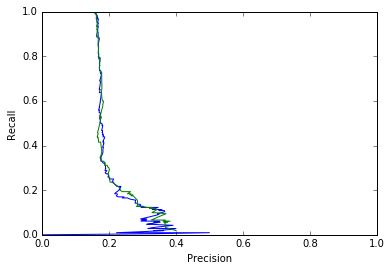

In [32]:
mli.plot_pr_curves([y_test,y_test],[pred_probs_def1,pred_probs_complex_1])

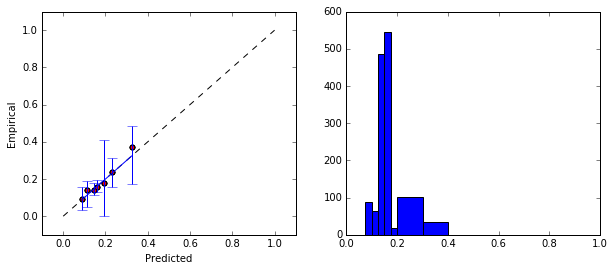

In [33]:

bins1 = np.linspace(0,.2,8+1)
bins2 = np.linspace(.2,1,8+1)
bins_final = np.unique(np.concatenate((bins1, bins2)))
plt.figure(figsize=(10,4))
mli.plot_reliability_diagram(y_test,pred_probs_complex_1,size_points=False, 
                             bins=bins_final, show_histogram=True);

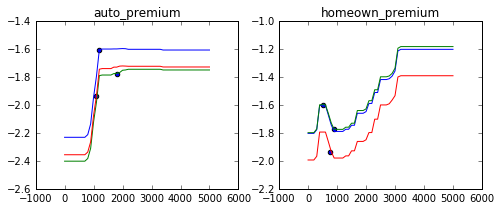

In [34]:
mli.ice_plot(model=xgb_complex1, 
             column_names=X_train_1.columns, 
             range_pts=rd, 
             base_data=test_sample_1,
             y_scaling='logit')

## Questions
- ### Which model looks more "coherent" ?
- ### Which model would you feel more comfortable justifying to your boss / clients?
- ### Which model will provide a better "user experience"?
- ### Which model do you expect to generalize better to new cases?

## One more question
- ### What do you think accounts for the non-monotonicity of the response wrt the premiums?

### Next model: Add in one additional feature

In [35]:
features_1a = ['auto_premium','homeown_premium'
                 ,'avg_homeown_rate_in_state']

In [36]:
X_train_1a = df_ins.loc[df_ins[chosen_fold_variant]!=test_fold_num,features_1a]
X_test_1a = df_ins.loc[df_ins[chosen_fold_variant]==test_fold_num,features_1a]


In [37]:
xgb_complex1a= xgb.XGBClassifier(n_estimators=3000, learning_rate=.01, gamma=5, max_depth=3,
                                 subsample=.8, reg_lambda=3)


In [38]:
xgb_complex1a.fit(X_train_1a,y_train, eval_metric='logloss',
                  eval_set=[(X_test_1a, y_test)], early_stopping_rounds=50)

[0]	validation_0-logloss:0.687633
Will train until validation_0-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.682155
[2]	validation_0-logloss:0.676769
[3]	validation_0-logloss:0.671567
[4]	validation_0-logloss:0.666418
[5]	validation_0-logloss:0.661365
[6]	validation_0-logloss:0.656466
[7]	validation_0-logloss:0.651609
[8]	validation_0-logloss:0.646844
[9]	validation_0-logloss:0.642166
[10]	validation_0-logloss:0.637582
[11]	validation_0-logloss:0.633123
[12]	validation_0-logloss:0.628737
[13]	validation_0-logloss:0.624364
[14]	validation_0-logloss:0.620085
[15]	validation_0-logloss:0.615948
[16]	validation_0-logloss:0.611784
[17]	validation_0-logloss:0.607811
[18]	validation_0-logloss:0.603806
[19]	validation_0-logloss:0.599944
[20]	validation_0-logloss:0.596101
[21]	validation_0-logloss:0.592349
[22]	validation_0-logloss:0.588679
[23]	validation_0-logloss:0.585123
[24]	validation_0-logloss:0.581596
[25]	validation_0-logloss:0.578082
[26]	validation_0-logloss:0.5746

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=3000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=3, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [39]:
pred_probs_complex_1a = xgb_complex1a.predict_proba(X_test_1a)[:,1]

In [40]:
roc_auc_score(y_test, pred_probs_complex_1a), log_loss(y_test, pred_probs_complex_1a)

(0.8119658835751868, 0.35409770229962195)

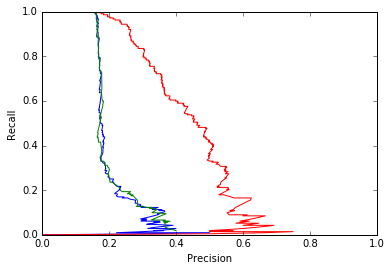

In [41]:
mli.plot_pr_curves([y_test,y_test, y_test],[pred_probs_def1,pred_probs_complex_1, pred_probs_complex_1a])

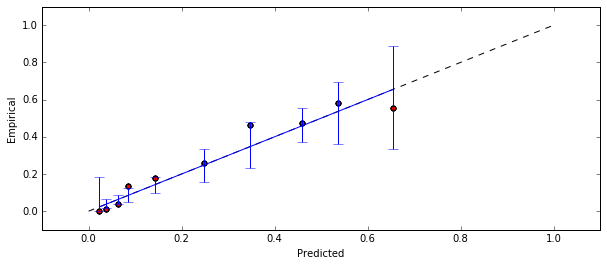

In [42]:
bins1 = np.linspace(0,.1,5)
bins2 = np.linspace(.2,1,9)
bins_final = np.unique(np.concatenate((bins1, bins2)))
plt.figure(figsize = (10,4))
mli.plot_reliability_diagram(y_test,pred_probs_complex_1a,size_points=False, 
                             bins=bins_final);

In [43]:
rd['avg_homeown_rate_in_state'] = np.unique(X_train_1a.avg_homeown_rate_in_state)

In [44]:
# Choose a few test points
np.random.seed(0)
test_sample_1a = X_test_1a.sample(3)

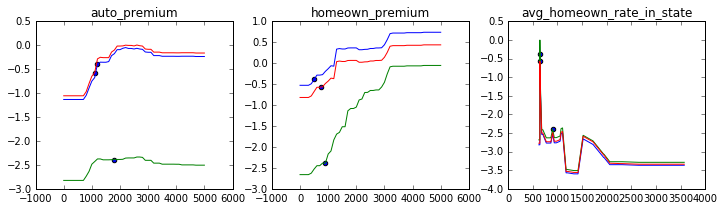

In [45]:
mli.ice_plot(model=xgb_complex1a, 
             column_names=X_train_1a.columns, 
             range_pts=rd, 
             base_data=test_sample_1a,
             y_scaling='logit')

## Question
- ### What conclusions do you draw from the shapes of the curves above?

### Next model: Add in a bunch more variables

In [46]:
features_2 = ['auto_premium','homeown_premium', 'home_dwell_cov', 'home_pers_prop_cov',
                'num_home_pol',
                'yob_policyholder','min_vehicle_year', 'max_vehicle_year', 'num_vehicles',
                  'max_driver_yob', 'min_driver_yob',
                'median_household_income','median_house_value'
                  ,'avg_homeown_rate_in_state'
                ]

In [47]:
X_train_2 = df_ins.loc[df_ins[chosen_fold_variant]!=test_fold_num,features_2]
X_test_2 = df_ins.loc[df_ins[chosen_fold_variant]==test_fold_num,features_2]


In [48]:
xgb_complex2 = xgb.XGBClassifier(n_estimators = 3000, learning_rate=.01, 
                                 max_depth=3, subsample=.8, gamma=5, 
                                 reg_alpha=2, reg_lambda=5)
xgb_complex2.fit(X_train_2,y_train, eval_metric='logloss', 
                 eval_set=[(X_test_2, y_test)], early_stopping_rounds=50)
pred_probs_complex2 = xgb_complex2.predict_proba(X_test_2)[:,1]

[0]	validation_0-logloss:0.687536
Will train until validation_0-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.682053
[2]	validation_0-logloss:0.676602
[3]	validation_0-logloss:0.671373
[4]	validation_0-logloss:0.666172
[5]	validation_0-logloss:0.661181
[6]	validation_0-logloss:0.656218
[7]	validation_0-logloss:0.651351
[8]	validation_0-logloss:0.646551
[9]	validation_0-logloss:0.641786
[10]	validation_0-logloss:0.637168
[11]	validation_0-logloss:0.632632
[12]	validation_0-logloss:0.62817
[13]	validation_0-logloss:0.623783
[14]	validation_0-logloss:0.619456
[15]	validation_0-logloss:0.615278
[16]	validation_0-logloss:0.611075
[17]	validation_0-logloss:0.607031
[18]	validation_0-logloss:0.603032
[19]	validation_0-logloss:0.599095
[20]	validation_0-logloss:0.595246
[21]	validation_0-logloss:0.591518
[22]	validation_0-logloss:0.587814
[23]	validation_0-logloss:0.584172
[24]	validation_0-logloss:0.580573
[25]	validation_0-logloss:0.576995
[26]	validation_0-logloss:0.57353

In [49]:
roc_auc_score(y_test, pred_probs_complex2), log_loss(y_test, pred_probs_complex2)

(0.8452570461476592, 0.32573712488875817)

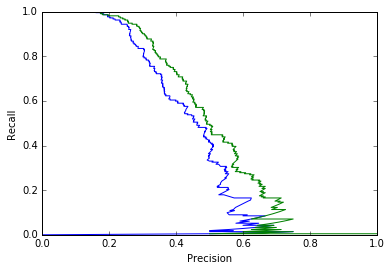

In [50]:
mli.plot_pr_curves([y_test, y_test],[pred_probs_complex_1a,pred_probs_complex2])

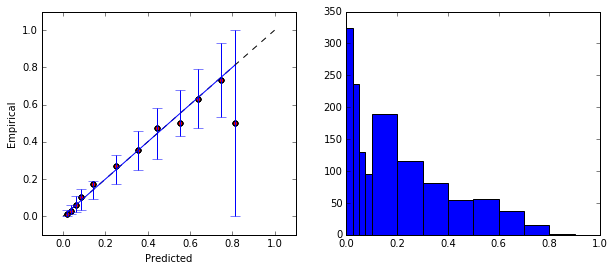

In [51]:
bins1 = np.linspace(0,.1,5)
bins2 = np.linspace(.2,1,9)
bins_final = np.unique(np.concatenate((bins1, bins2)))
plt.figure(figsize = (10,4))
mli.plot_reliability_diagram(y_test,pred_probs_complex2,size_points=False, 
                             bins=bins_final, show_histogram=True);

In [52]:
# Choose a few test points
np.random.seed(0)
test_sample_2 = X_test_2.sample(3)

In [53]:
# Get reasonable ranges for all variables
rd = mli.get_range_dict(X_train_2)
rd['auto_premium'] = np.linspace(0, 5000, 51)
rd['homeown_premium'] = np.linspace(0, 5000, 51)
rd['home_dwell_cov'] = np.linspace(0,1000000,101)
rd['home_pers_prop_cov'] = np.linspace(0,1000000,101)
rd['num_home_pol'] = np.arange(6)
rd['yob_policyholder'] = np.arange(1920,2000)
rd['max_driver_yob'] = np.arange(1920,2005)
rd['min_driver_yob'] = np.arange(1920,2005)

rd['min_vehicle_year'] = np.arange(1980,2020)
rd['max_vehicle_year'] = np.arange(1980,2020)
rd['median_household_income'] = np.linspace(0,500000,101)
rd['median_house_value'] = np.linspace(0,500000,101)


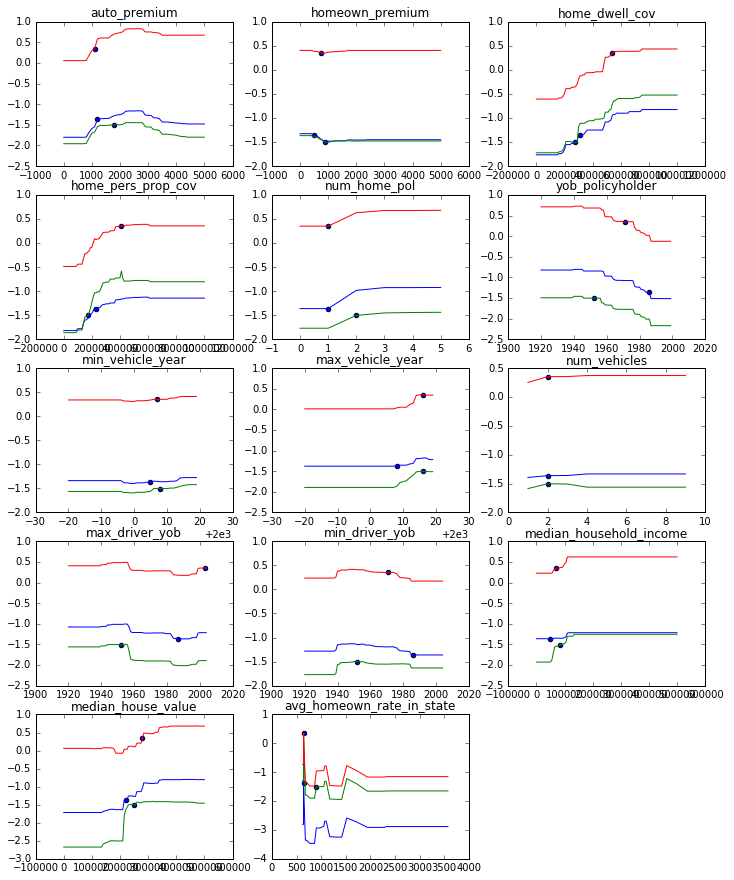

In [54]:
mli.ice_plot(model=xgb_complex2, 
             column_names=X_train_2.columns, 
             range_pts=rd, 
             base_data=test_sample_2,
             y_scaling='logit')

### For comparison sake, let's look at the default XGB settings

In [55]:
xgb_def2 = xgb.XGBClassifier()
xgb_def2.fit(X_train_2,y_train)
pred_probs_def2 = xgb_def2.predict_proba(X_test_2)[:,1]

In [56]:
roc_auc_score(y_test, pred_probs_def2), log_loss(y_test, pred_probs_def2)

(0.8410720868661818, 0.3292322508310892)

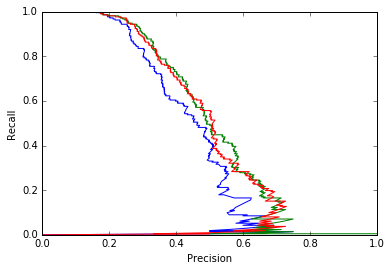

In [57]:
mli.plot_pr_curves([y_test, y_test, y_test],[pred_probs_complex_1a,pred_probs_complex2, pred_probs_def2])

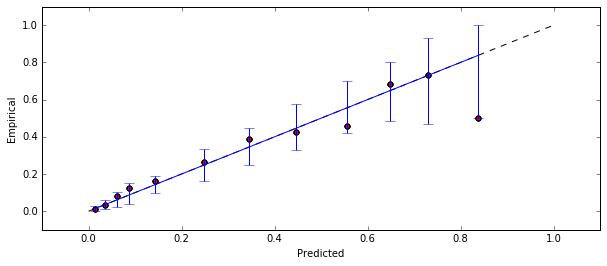

In [58]:
bins1 = np.linspace(0,.1,5)
bins2 = np.linspace(.2,1,9)
bins_final = np.unique(np.concatenate((bins1, bins2)))
plt.figure(figsize = (10,4))
mli.plot_reliability_diagram(y_test,pred_probs_def2,size_points=False, 
                             bins=bins_final);

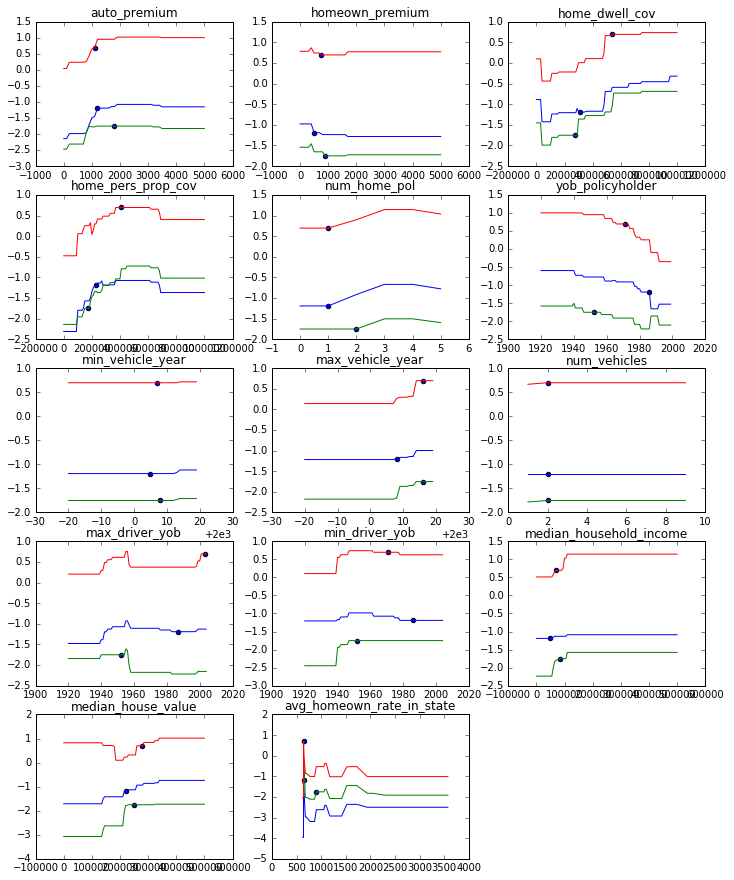

In [59]:
mli.ice_plot(model=xgb_def2, 
             column_names=X_train_2.columns, 
             range_pts=rd, 
             base_data=test_sample_2,
             y_scaling='logit')

## Summary of Part I
- ### Model understanding is still possible even when models are more complex
- ### Need to broaden your thinking beyond the assumptions of linear / logistic regression
- ### Effects of a variable are not constant across its range of values (non-linearity)
- ### Shape of the response curve may vary depending on values of other variables (interactions)
- ### But can still explore and understand them!



## Part II: Giving reasons to model predictions

- ### In the previous, we focused our attention to understanding the overall dynamics of the model.

- ### However, in many cases,  we want to understand the reasons behind a specific prediction.

## Goal: 
- ### Explain why a particular instance is "different" from average.
- ### Which features / concepts contributed most to its "distinctiveness"?
- ### Can we attribute the "distance from average" of a particular case to the individual features?


## SHAP

### Idea: 

- #### arbitrarily order the features $X_1, X_2, \ldots, X_k$.

- #### Compare $P(Y=1|X_1 = x_1, X_2 = x_2, \ldots, X_{j-1}=x_{j-1})$ to $P(Y=1|X_1 = x_1, X_2 = x_2, \ldots, X_j=x_j)$ (actually, compare the log odds) and attribute the difference to feature $X_j$ being equal to $x_j$.

- #### Average the "attributions" to a feature over all possible orderings of the features

### This is motivated by the "Shapley Value" in Game Theory 
### Same approach attributes ~98% of the "power" in the Security Council to the 5 permanent members

The "magic" of SHAP is that step (3) (averaging over all possible orderings) is typically computationally prohibitive, but for tree-based models they found a clever way to compute it effeciently.

### End Result
Given a particular data point and its prediction, we can assign numerical values to each feature such that the sum of those values represents the distance between the "baseline" average and the predicted value.

### References
*A Unified Approach to Interpreting Model Predictions*
Scott Lundberg, Su-In Lee
https://arxiv.org/abs/1705.07874

*Consistent Individualized Feature Attribution for Tree Ensembles*
Scott M. Lundberg, Gabriel G. Erion, Su-In Lee
https://arxiv.org/abs/1802.03888


In [60]:
reas_df = mli.get_reason_score_matrix(xgb_complex2, X_test_2)
reas_df.head()

,auto_premium,homeown_premium,home_dwell_cov,home_pers_prop_cov,num_home_pol,yob_policyholder,min_vehicle_year,max_vehicle_year,num_vehicles,max_driver_yob,min_driver_yob,median_household_income,median_house_value,avg_homeown_rate_in_state,Intercept
0,0.132014,-0.036204,-0.367512,-0.323878,-0.027658,-0.341242,-0.014951,-0.149959,0.029395,-0.130703,-0.078100,-0.168647,-0.468083,-0.110768,-1.870156
1,-0.075509,-0.058472,0.086331,0.102120,-0.022519,-0.030488,-0.009265,-0.132396,0.024897,0.140688,0.003818,-0.137645,0.260377,-0.796689,-1.870156
2,-0.086212,-0.045100,-0.621088,-0.514735,0.240809,-0.007001,0.050180,0.058438,0.002834,0.108347,0.005645,-0.178793,-0.534998,-0.126719,-1.870156
3,-0.136486,0.031929,-0.615474,-0.583732,0.206541,-0.031477,-0.045101,0.055723,0.004269,-0.049392,0.000136,-0.129630,-0.517090,-0.482353,-1.870156
4,-0.156577,0.034294,0.628371,0.521214,0.140404,-0.055454,-0.025596,0.070806,-0.007332,-0.086076,-0.002980,-0.292293,-0.065690,-0.730371,-1.870156


In [61]:
## get_reason_matrix is essentially the following 3 lines
# X_test_dmat = xgb.DMatrix(X_test_2)
# reas_mat = xgb_complex2.get_booster().predict(X_test_dmat, pred_contribs=True)
# reas_df_2 = pd.DataFrame(reas_mat, columns = list(X_test_2.columns)+['Intercept'])
# reas_df_2.head()

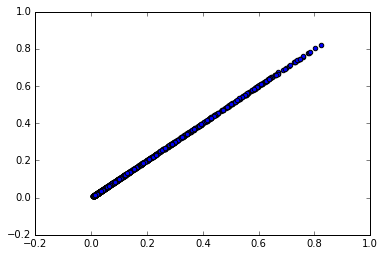

In [62]:
## Demonstrate that these numbers sum up to the overall log_odds

log_odds_vec = np.sum(reas_df, axis=1)
pv = 1/(1+np.exp(-log_odds_vec))
plt.scatter(pv, pred_probs_complex2)

In [63]:
mask = np.abs(pv-pred_probs_complex2)>.01
np.sum(mask)

0

In [64]:
## Let's examine a specific case
row_num = 72
case_df = pd.DataFrame(X_test_2.iloc[row_num])
case_df['feat_importance'] = pd.DataFrame(reas_df.iloc[row_num])
case_df.columns = ['feat_value', 'feat_importance']

In [65]:
case_df.sort_values('feat_importance', ascending=False)

,feat_value,feat_importance
home_dwell_cov,760000.0,0.744315
home_pers_prop_cov,380000.0,0.493349
auto_premium,2450.0,0.142085
max_vehicle_year,2018.0,0.083670
min_vehicle_year,2017.0,0.074119
min_driver_yob,1956.0,0.044326
yob_policyholder,1960.0,0.030441
num_vehicles,2.0,0.026435
homeown_premium,2600.0,0.021991
num_home_pol,1.0,-0.026817


In [66]:
# Assess the impact of each feature "overall"
# by calculating the average "impact" of each variable
reas_df.abs().mean().sort_values(ascending=False)

Intercept                    1.870137
avg_homeown_rate_in_state    0.510019
home_pers_prop_cov           0.387286
home_dwell_cov               0.341805
median_house_value           0.328445
yob_policyholder             0.169387
median_household_income      0.128389
max_driver_yob               0.111908
auto_premium                 0.105168
max_vehicle_year             0.088370
num_home_pol                 0.046333
min_driver_yob               0.034745
min_vehicle_year             0.031603
num_vehicles                 0.029607
homeown_premium              0.028269
dtype: float32

In [67]:
## Look at correlations between the reasons
pd.DataFrame(np.round(np.corrcoef(reas_df.values[:,:-1].T), decimals=2), columns = reas_df.columns[:-1], index = reas_df.columns[:-1])

,auto_premium,homeown_premium,home_dwell_cov,home_pers_prop_cov,num_home_pol,yob_policyholder,min_vehicle_year,max_vehicle_year,num_vehicles,max_driver_yob,min_driver_yob,median_household_income,median_house_value,avg_homeown_rate_in_state
auto_premium,1.00,-0.12,0.01,0.02,0.00,-0.09,0.00,0.12,0.20,-0.08,-0.02,-0.00,0.08,0.06
homeown_premium,-0.12,1.00,-0.00,-0.03,0.04,0.02,0.07,0.01,-0.04,0.01,-0.00,0.06,0.05,0.13
home_dwell_cov,0.01,-0.00,1.00,0.88,0.12,0.12,0.11,0.16,0.22,0.04,0.12,0.31,0.46,0.08
home_pers_prop_cov,0.02,-0.03,0.88,1.00,0.09,0.13,0.10,0.15,0.20,0.05,0.13,0.33,0.42,0.15
num_home_pol,0.00,0.04,0.12,0.09,1.00,0.14,0.01,0.03,0.03,0.12,0.09,0.08,0.07,-0.01
yob_policyholder,-0.09,0.02,0.12,0.13,0.14,1.00,-0.07,-0.05,-0.02,0.74,0.52,-0.03,0.03,0.04
min_vehicle_year,0.00,0.07,0.11,0.10,0.01,-0.07,1.00,0.40,-0.28,-0.00,-0.02,0.14,0.04,-0.05
max_vehicle_year,0.12,0.01,0.16,0.15,0.03,-0.05,0.40,1.00,0.17,-0.06,0.07,0.15,0.06,-0.08
num_vehicles,0.20,-0.04,0.22,0.20,0.03,-0.02,-0.28,0.17,1.00,-0.08,0.11,0.04,0.08,0.02
max_driver_yob,-0.08,0.01,0.04,0.05,0.12,0.74,-0.00,-0.06,-0.08,1.00,0.41,-0.06,-0.00,0.03


In [68]:
def analyze_effect(feature_name, reas_df, test_df, fillna_val=0):
    plt.subplot(2,2,1)
    plt.scatter(test_df[feature_name].fillna(fillna_val), reas_df[feature_name], alpha=.1)
    plt.subplot(2,2,2)
    plt.scatter(reas_df[feature_name], test_df[feature_name].fillna(fillna_val), alpha=.1)
    plt.subplot(2,2,3)
    plt.hist(test_df[feature_name].fillna(fillna_val))
    plt.subplot(2,2,4)
    plt.hist(reas_df[feature_name])
                

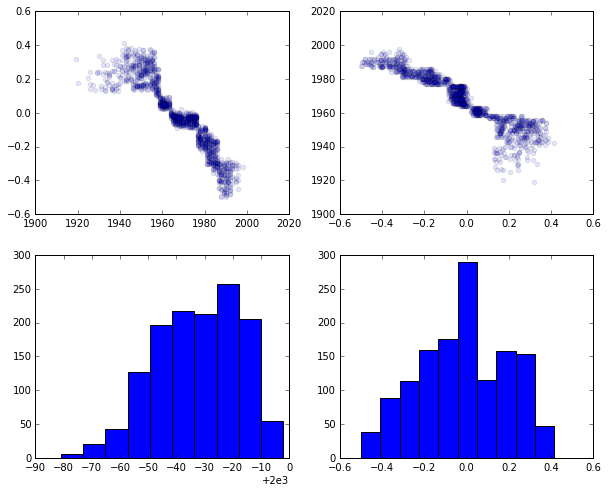

In [69]:
plt.figure(figsize=(10,8))
analyze_effect('yob_policyholder',reas_df, X_test_2, fillna_val=1900)

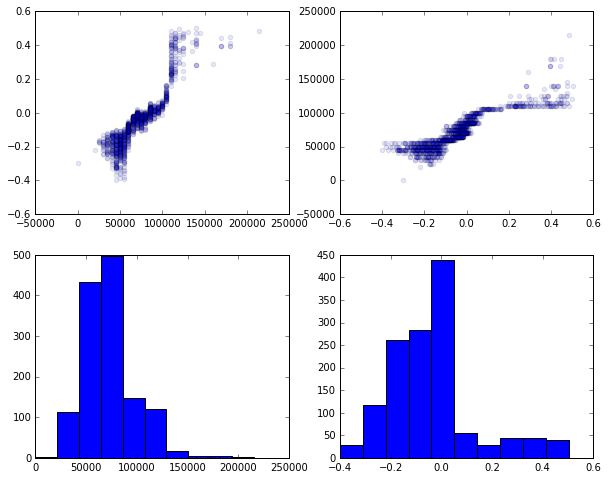

In [70]:
plt.figure(figsize=(10,8))
analyze_effect('median_household_income',reas_df, X_test_2, fillna_val=0)

In [71]:
# plt.figure(figsize=(10,8))
# analyze_effect('auto_premium',reas_df, X_test_2, fillna_val=-1000)

In [72]:
# plt.figure(figsize=(10,8))
# analyze_effect('median_house_value',reas_df, X_test_2, fillna_val=-1000)

In [73]:
# plt.figure(figsize=(10,8))
# analyze_effect('median_household_income',reas_df, X_test_2, fillna_val=-10000)

## Consolidating Reasons for better Interpretability
Often, ascribing value to individual features may yield confusing results.   For example, many individual features may represent the same concept or otherwise be highly correlated.  In these cases, it may be somewhat arbitary which of the correlated features gets "credit" for the impact.  In other cases, there may be many similar variables, each of which has a tiny impact, but collectively have a much greater impact.  For this reason, we may want to "consolidate" the impact of features.

In [74]:
# Create a dictionary mapping the "group name" to the list of features included in that group
reason_mapping_umb = {
              'Value_of_Real_Estate':['homeown_premium', 'home_dwell_cov','home_pers_prop_cov','num_home_pol'],
              'State_Specific_Factors':['avg_homeown_rate_in_state'],
              'Value_of_Automobiles':['min_vehicle_year', 'max_vehicle_year', 'num_vehicles','auto_premium'],
              'Age_of_Policyholder_and_Family':['yob_policyholder', 'min_driver_yob', 'max_driver_yob'],
              'Zipcode_Wealth':['median_household_income','median_house_value']}

In [75]:
cons_df = mli.consolidate_reason_scores(reas_df, reason_mapping_umb)

In [76]:
cons_df.head()

,Value_of_Real_Estate,State_Specific_Factors,Value_of_Automobiles,Age_of_Policyholder_and_Family,Zipcode_Wealth
0,-0.755253,-0.110768,-0.003501,-0.550045,-0.636730
1,0.107459,-0.796689,-0.192273,0.114018,0.122732
2,-0.940113,-0.126719,0.025241,0.106991,-0.713791
3,-0.960737,-0.482353,-0.121594,-0.080733,-0.646720
4,1.324282,-0.730371,-0.118699,-0.144511,-0.357983


In [77]:
cons_df.abs().mean().sort_values(ascending=False)

Value_of_Real_Estate              0.713722
State_Specific_Factors            0.510019
Zipcode_Wealth                    0.427924
Age_of_Policyholder_and_Family    0.277580
Value_of_Automobiles              0.153941
dtype: float32

In [78]:
## Look at correlations between the reasons
pd.DataFrame(np.round(np.corrcoef(cons_df.values.T), decimals=2), columns = cons_df.columns, index = cons_df.columns)

,Value_of_Real_Estate,State_Specific_Factors,Value_of_Automobiles,Age_of_Policyholder_and_Family,Zipcode_Wealth
Value_of_Real_Estate,1.00,0.12,0.15,0.13,0.47
State_Specific_Factors,0.12,1.00,-0.01,0.04,0.29
Value_of_Automobiles,0.15,-0.01,1.00,-0.09,0.12
Age_of_Policyholder_and_Family,0.13,0.04,-0.09,1.00,0.01
Zipcode_Wealth,0.47,0.29,0.12,0.01,1.00


In [79]:
reason_string_vector = mli.predict_reason_strings(xgb_complex2, X_test_2, reason_mapping_umb, .3)

In [80]:
pd.Series(reason_string_vector[pred_probs_complex2>.5]).value_counts()

Value_of_Real_Estate;Zipcode_Wealth                                                          24
State_Specific_Factors;Zipcode_Wealth                                                        16
State_Specific_Factors;Value_of_Real_Estate;Zipcode_Wealth                                   15
State_Specific_Factors;Value_of_Real_Estate                                                  12
State_Specific_Factors;Zipcode_Wealth;Value_of_Real_Estate                                    7
State_Specific_Factors;Age_of_Policyholder_and_Family;Value_of_Real_Estate;Zipcode_Wealth     7
Value_of_Real_Estate;Zipcode_Wealth;Age_of_Policyholder_and_Family                            7
Value_of_Real_Estate;State_Specific_Factors;Zipcode_Wealth                                    4
State_Specific_Factors;Age_of_Policyholder_and_Family;Value_of_Real_Estate                    3
State_Specific_Factors;Age_of_Policyholder_and_Family                                         3
State_Specific_Factors;Age_of_Policyhold

## SHAP Package
The SHAP package is continually adding new features and visualization capabilities.  Here we explore a few basics

In [81]:
# if needed
# !pip install shap 

In [82]:
import shap
shap.initjs()
#X_test_2_sm = X_test_2

In [83]:
explainer = shap.TreeExplainer(xgb_complex2)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [84]:
shap_values = explainer.shap_values(X_test_2)

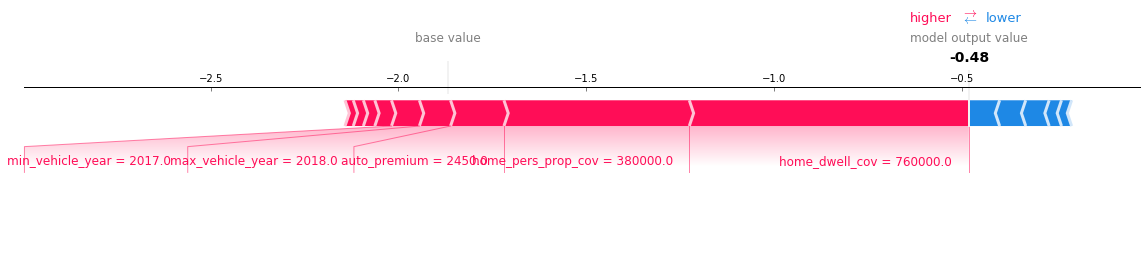

In [85]:
row_num=72
shap.force_plot(explainer.expected_value, shap_values[row_num,:], X_test_2.iloc[row_num,:], matplotlib=True)

In [86]:
cons_shap_df = mli.consolidate_reason_scores(pd.DataFrame(shap_values, columns=X_test_2.columns), reason_mapping_umb)

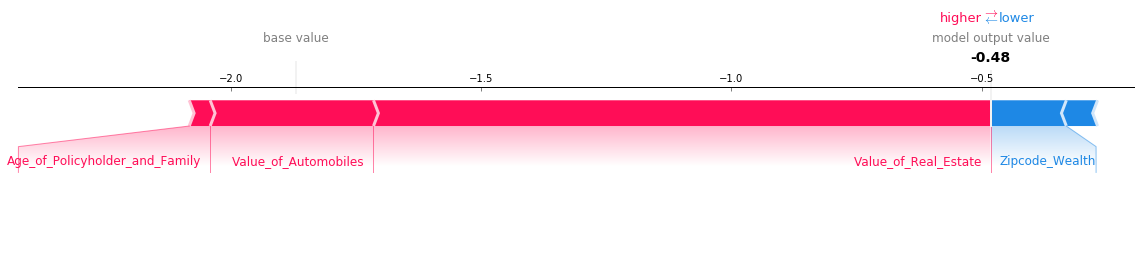

In [87]:
shap.force_plot(explainer.expected_value, cons_shap_df.iloc[row_num,:].values, feature_names=cons_shap_df.columns,matplotlib=True)

### Interesting interaction between age and neighborhood income

In [88]:
shap_interaction_values = shap.TreeExplainer(xgb_complex2).shap_interaction_values(X_test_2)

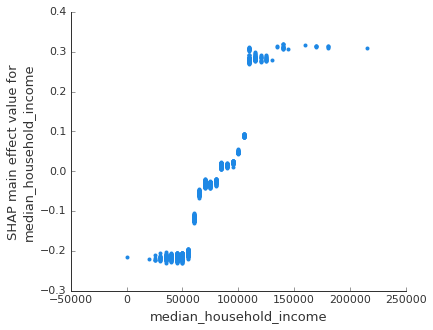

In [89]:
shap.dependence_plot(
    ("median_household_income", "median_household_income"),
    shap_interaction_values, X_test_2,
    display_features=X_test_2
)

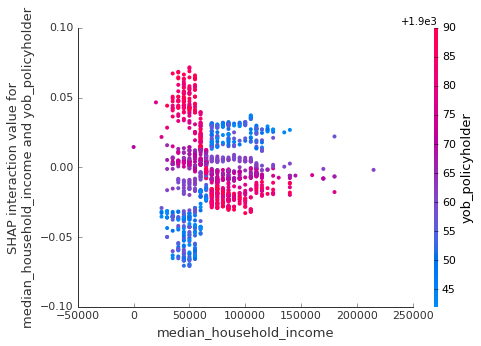

In [90]:
shap.dependence_plot(
    ("median_household_income", "yob_policyholder"),
    shap_interaction_values, X_test_2,
    display_features=X_test_2
)

# Wrap-up

- ## Please rate this talk on the ODSC app!
- ## Check out / Subscribe to my YouTube channel: https://www.youtube.com/channel/UCfsbASar8nsLs4NbhQwuaVg
- ## Sign up at www.numeristical.com to participate in Live Events
- ## ODSC Live Training "Gradient Boosting for Prediction and Inference" (4 Hour workshop): November 10th. https://aiplus.odsc.com/courses/gradient-boosting-for-prediction-and-inference
- ## If you find the ml_insights package useful, please give it a star on Github!
